In [90]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

np.random.seed(123)

## 最小木問題とは

- 問題設定
    - 重みつき無向グラフをG=(V,E,c), n = |V|, m = |E|, $c: E \to \mathbb{R}$ とする
    - **最小全域木(MST)** := 部分グラフ(V,E') のうち重みの総和が最小になる木
- アルゴリズム
    - Kruskal法: 辺を重みが小さい順に並べ、閉路にならないときE'に順に加えていく。

## 最小木問題の定式化

辺$e$ ごとに0-1変数$x_e$ を用意する。部分グラフで採用する $\iff x_e = 1$ となる。

必要条件として、 $\sum_{e \in E} x_e = n-1$ がある。
その他に木になるための条件が必要で、いくつかの定式化がある。

### 閉路除去定式化

頂点部分集合$S \subset V$ について $E(S) \subset E$ を端点が両方とも$S$ に含まれる辺の集合とする。  
任意の$S$ について、$S$ が閉路になっていない $\iff \sum_{e \in S} x_e \leq |S|-1$ なので、これを条件にいれる。

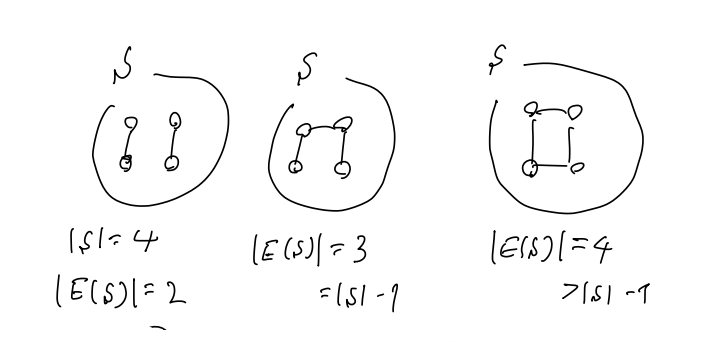

直観的な意味: 閉路ができるなら、閉路になる頂点らをSとして選べば制約に違反する。

### カットセット定式化

カット$\delta(S) \subset E$ を辺の部分集合で端点の片方のみが$S$ に含まれるものとする。  
定義から $E = E(S) \cup E(V - S) \cup \delta(S)$ である。

閉路除去制約を仮定すると

$$
\begin{align}
n - 1 = |E| &= \sum_{e \in E} x_e + \sum_{e \in E-S} x_e + \sum_{e \in \delta(S)} x_e \\
 &\leq (|S| - 1) + (n - |S| - 1) + \sum_{e \in \delta(S)} x_e \\
 &= n - 2 + \sum_{e \in \delta(S)} x_e
\end{align}
$$
が成り立つので、$1 \leq \sum_{e \in \delta(S)} x_e$ である。この不等式制約をカットセット制約という。

閉路除去制約はカットセット制約より真に強い定式化らしい。

note: (AがBより強い定式化 $\iff$ 実行可能領域が同じかつ、Aの緩和問題の実行可能領域がBに含まれる)

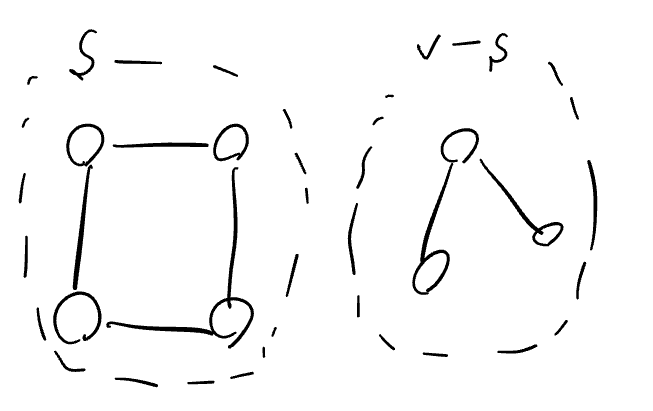

直観的な意味: もし非連結になるなら、片側の連結成分をすべてSとすれば、カットは0になる

### 単品種流定式化

今までの定式化は入力に対して指数個の制約が必要になっている。
カットセット制約を最大フロー・最小カット定理で言い換えることで多項式個の制約に置き換える。

note: 最大フロー・最小カット定理: 始点s, 終点t とするとそのカット$(S,T)$ とは$s\in S, t\in T, V=S\uplus T$ となる対である。このとき "(s,t) の最大フロー" = "(S,T) の最小カット"

適当に頂点0を決め、他のすべての頂点にフローを流すことを考える。「最小カットが1以上」は「最大フローが1以上」と等価になる。  
よって頂点0から$n-1$を流し入れ, その他の頂点から1ずつ出すフローが存在するかを制約として表現する。

定式化では新たに決定変数 "$f_{ij}$ := $i$ から$j$ に向かうフローの量" を導入する。

### 多品種流定式化

流量1のフローをそれぞれの頂点ごとに区別して流す。

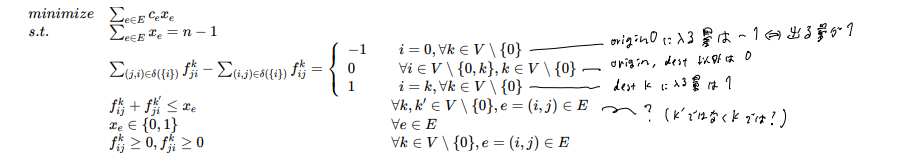

## 最小木問題(MST) networkx の利用

In [91]:
## スパイ同士の通信路とコストの定義
G = nx.Graph()
G.add_edge("Arigator", "WhiteBear", weight=2)
G.add_edge("Arigator", "Bull", weight=1)
G.add_edge("Bull", "WhiteBear", weight=1)
G.add_edge("Bull", "Shark", weight=3)
G.add_edge("WhiteBear", "Condor", weight=3)
G.add_edge("WhiteBear", "Shark", weight=5)
G.add_edge("Shark", "Condor", weight=4)

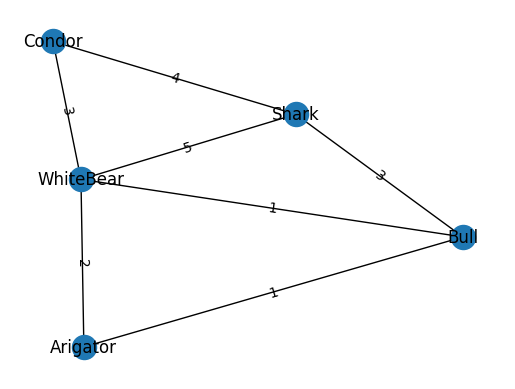

In [92]:
# 描画
pos = nx.spring_layout(G)  # Compute layout for graph
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))  # Draw edge weights
nx.draw(G, pos, with_labels=True)  # Draw nodes with labels

[('Arigator', 'Bull'), ('WhiteBear', 'Bull'), ('WhiteBear', 'Condor'), ('Bull', 'Shark')]


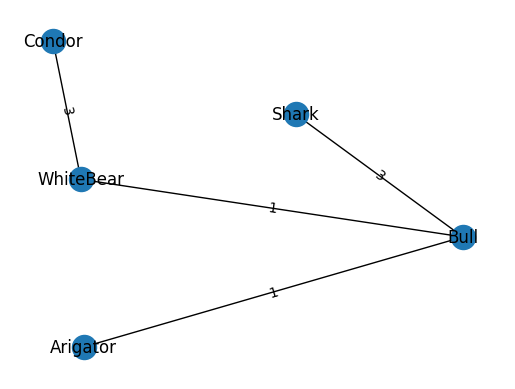

In [93]:
mst_edges = nx.minimum_spanning_tree(G).edges()
print(mst_edges)

# 描画
mst = G.edge_subgraph(mst_edges)
nx.draw_networkx_edge_labels(mst, pos, edge_labels=nx.get_edge_attributes(mst, 'weight'))  # Draw edge weights
nx.draw(mst, pos, with_labels=True)  # Draw nodes with labels

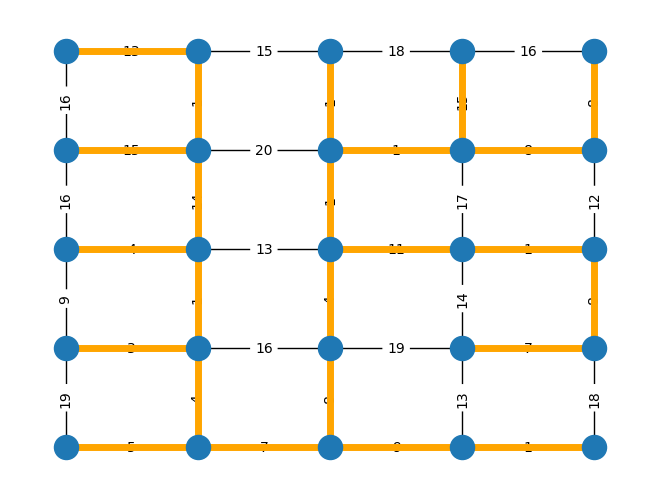

In [94]:
# ランダムな格子グラフ
m, n = 5, 5
lb, ub = 1, 20
random.seed(1)
G = nx.grid_2d_graph(m, n)
for (i, j) in G.edges():
    G[i][j]["weight"] = random.randint(lb, ub)
pos = {(i, j): (i, j) for (i, j) in G.nodes()}

edges = list(nx.minimum_spanning_edges(G))

plt.figure()
nx.draw(G, pos=pos, node_size=100)
edge_labels = {}
for (i, j) in G.edges():
    edge_labels[i, j] = f"{ G[i][j]['weight'] }"
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, pos=pos, width=5, edgelist=edges, edge_color="orange")
plt.show()

## k分割問題

- グラフをk個のクラスタ(森)に分割し、異なる連結成分同士の最短距離の最大化をしたい
- MST からk-1 本辺を大きい順に削除すれば良い
    - 証明
    - k個の連結成分の頂点を$C_1,...,C_k$ とする
    - $C_i, C_j$ のクラスタの最短距離は $d_{ij} = \min_{e \in \delta(C_i, C_j)}{c_e} = c(C_i,C_j)$, ただし $c(C_i,C_j)$ は$(C_i,C_j)$ の最小カット
    - よって $d = \min_{1 \leq i < j \leq k}{d_{ij}}$ を最大化することと同値
    - MST $T$ から辺$e$ を削除してクラスタ$C_1, C_2$ に分かれたとする
    - カット$(C_1, C_2)$ は$c_e$ になる
        - なぜならば、カットが$c_e$ 未満ならそれを満たす辺$c_{e'}$ と$e$ を取り替えることで$T$ より小さい最小全域木を作れるから
    - よって$T$ から一番大きい辺を取り除いて得られた最短距離が$d$ の最大値になる
    - また、クラスタ$C_1, C_2$ の$C_1$ を更に分割して$C_{11}, C_{12}, C_2$ になったとする
    - このとき $c(C_1, C_2) \leq c(C_{11}, C_2), c(C_{12}, C_2)$ であるから、分割を増やすことで既存のクラスタとの最短距離が減少することはない
    - 以上より$T$ から辺を削除して得られるクラスタの最短距離の最大値は、$k-1$ 本辺を大きい順に削除して得られるものが最大になる
    - 疑問点: MST T 以外から始めてd が最大にならない理由

In [95]:
k = 4
weight = []
for (i, j, w) in edges:
    weight.append((w["weight"], i, j))
weight.sort(reverse=True)
max_distance=weight[k - 1 - 1][0]
print("weight=", weight)
print(f"{max_distance=}")

weight= [(15, (3, 3), (3, 4)), (15, (0, 3), (1, 3)), (14, (1, 2), (1, 3)), (13, (0, 4), (1, 4)), (11, (2, 2), (3, 2)), (9, (2, 0), (3, 0)), (8, (4, 3), (4, 4)), (8, (4, 1), (4, 2)), (8, (3, 3), (4, 3)), (8, (2, 0), (2, 1)), (7, (3, 1), (4, 1)), (7, (1, 0), (2, 0)), (5, (0, 0), (1, 0)), (4, (2, 1), (2, 2)), (4, (1, 0), (1, 1)), (4, (0, 2), (1, 2)), (3, (0, 1), (1, 1)), (1, (3, 2), (4, 2)), (1, (3, 0), (4, 0)), (1, (2, 3), (3, 3)), (1, (2, 3), (2, 4)), (1, (2, 2), (2, 3)), (1, (1, 3), (1, 4)), (1, (1, 1), (1, 2))]
max_distance=14


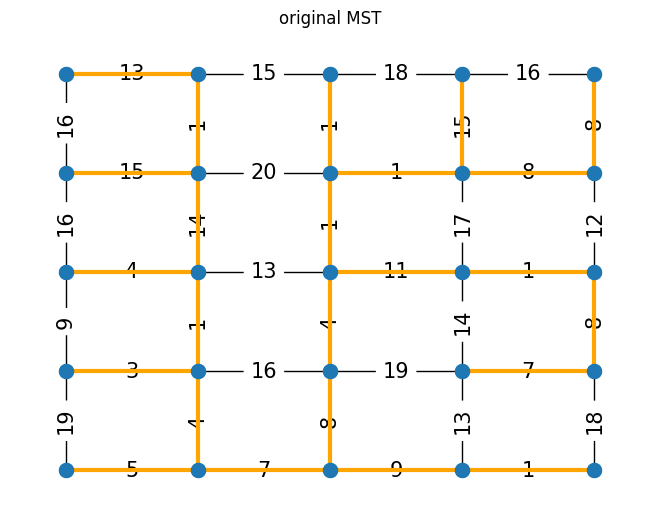

In [96]:
G1 = nx.Graph()
for (i, j, w) in edges:
    G1.add_edge(i, j)
nx.draw(G, pos=pos, node_size=100)
nx.draw_networkx_edge_labels(G, pos, font_size=15, edge_labels=edge_labels)
nx.draw(G1, pos=pos, node_size=100, width=3, edge_color="orange")
plt.title('original MST')
plt.show()

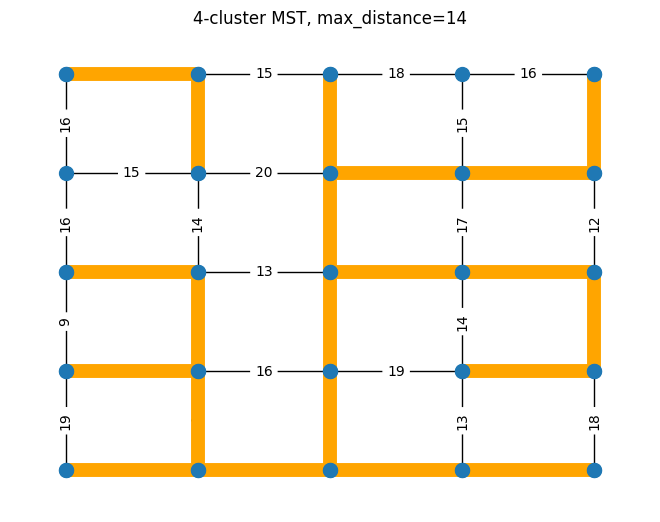

In [97]:
G1 = nx.Graph()
for (w, i, j) in weight[k-1:]:
    G1.add_edge(i, j)
nx.draw(G, pos=pos, node_size=100)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G1, pos=pos, node_size=100, width=10, edge_color="orange")

plt.title(f'{k}-cluster MST, {max_distance=}')
plt.show()

## 最小有向全域木

- 最小全域木を有向グラフにしたもの
- ある頂点を根とし、すべての頂点に到達可能な有向木のうちコストが最小なものを求める問題
- Chu-Liu/Edmonds' algorithm で、$O(nm)$ で計算可能。skew-heap などで工夫すると$O(m \log n)$
    - https://joisino.hatenablog.com/entry/2017/01/11/230141
    - https://ark4rk.hatenablog.com/entry/2017/09/15/011937
- 雑な概要:
    - 最小有向全域木は存在するならば、根以外の頂点の入次数は1、根は0
    - 辺を小さい順に舐めていき、入次数が1を超えなければ採用する
    - 辺を追加することでサイクルができてしまう場合、サイクルに含まれる頂点を縮約・コストを更新して処理を続ける
- [networkx.minimum_spanning_arborescence](https://networkx.org/documentation/stable/reference/algorithms/tree.html#module-networkx.algorithms.tree.branchings)

In [98]:
m, n = 3, 3
lb, ub = 1, 20
G = nx.grid_2d_graph(m, n)
D = G.to_directed()
for (i, j) in D.edges():
    D[i][j]["weight"] = random.randint(lb, ub)
pos = {(i, j): (i, j) for (i, j) in G.nodes()}

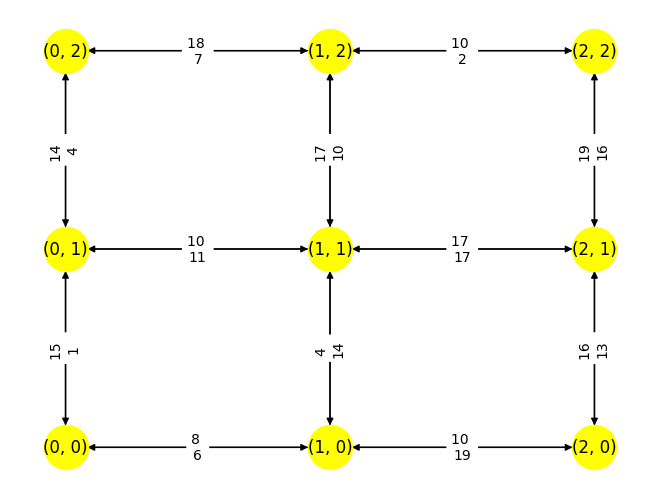

In [99]:
plt.figure()
nx.draw(D, pos=pos, with_labels=True, node_size=1000, node_color="yellow")
edge_labels = {}
for (i, j) in G.edges():
    edge_labels[i, j] = f"{D[i][j]['weight']} \n{D[j][i]['weight']}"
nx.draw_networkx_edge_labels(D, pos, edge_labels=edge_labels)
plt.show()

In [100]:
sol = nx.minimum_spanning_arborescence(D)
# edmonds = nx.tree.Edmonds(D)
# sol = edmonds.find_optimum(attr="weight", kind="min", style="arborescence")

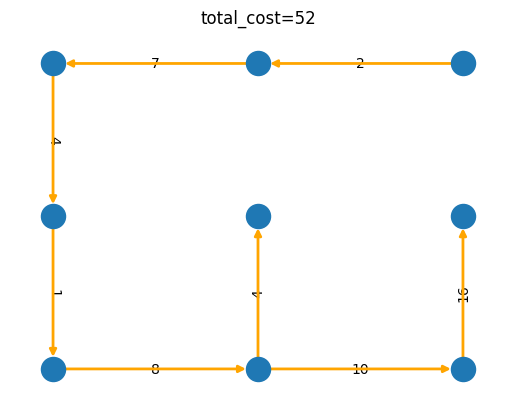

In [101]:
plt.figure()
edge_labels = {}
total_cost = 0
for (i, j) in sol.edges():
    edge_labels[i, j] = f"{D[i][j]['weight']}"
    total_cost += D[i][j]['weight']
nx.draw_networkx_edge_labels(D, pos, edge_labels=edge_labels)
nx.draw(D, pos=pos, width=2, edgelist=sol.edges(), edge_color="orange")
plt.title(f"{total_cost=}")
plt.show()